In [44]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import accuracy_score as accuracy

import random

## Process to understand how to get images

In [4]:
names = []
file = open('train/names.txt', 'r')
for line in file:
    names.append(line.rstrip())
file.close()

In [33]:
def encrypt(name_counter):
    t = []
    for i in range(0, len(names)):
        if i == name_counter:
            t.append(1)
        else:
            t.append(0)
    return t

def decipher(t):
    return names[np.argmax(t)]

images = []
target = []
name_counter = 0
for i in names:
    path = "".join(['train/', i, "/images.txt"])
    file=open(path, 'r')
    pics = []
    for line in file:
        pics.append(line.rstrip())
    file.close()
    pics = pics[1:]

    num = 0
    for j in pics:
        im = cv.imread("/".join(["train/", i , j]))
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        im = cv.resize(im, (128, 128))
        images.append(im)
        num += 1
    target += [encrypt(name_counter)] * num
    name_counter += 1

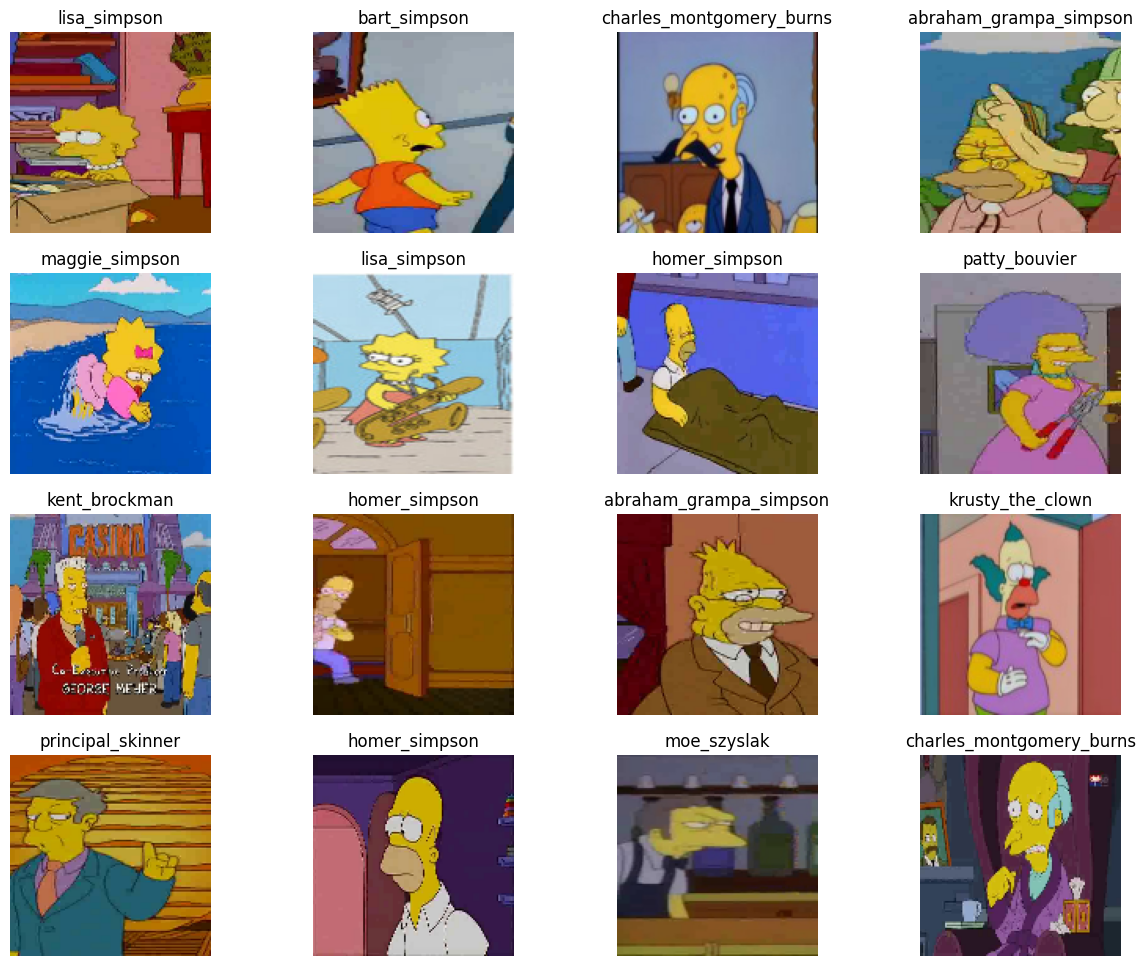

In [34]:
ids = np.random.randint(0, len(target), 16)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
for i in range(0, 4):
    for j in range(0, 4):
        axs[i, j].imshow(images[ids[i * 4 + j]])
        axs[i, j].set_title(decipher(target[ids[i * 4 + j]]))
        axs[i, j].axis("off")

## Create val folder from train folder

In [96]:
names = []
file = open('train/names.txt', 'r')
for line in file:
    names.append(line.rstrip())
file.close()

for i in names:
    path = "".join(['train/', i, "/images.txt"])
    file=open(path, 'r')
    pics = []
    for line in file:
        pics.append(line.rstrip())
    file.close()
    pics = pics[1:]

    N = len(pics)
    
    val_size = int(len(pics) * 0.1)
    val_id = random.sample(range(0, N), val_size)
    train_id = list(set(range(0, N)).difference(set(val_id)))
    
    with open("".join(['train/',i,"/train_images.txt"]), "w") as f:
        for j in range(0, len(train_id)):
            if j != len(train_id) - 1:
                f.write(pics[train_id[j]] + "\n")
            else:
                f.write(pics[train_id[j]])
        
    with open("".join(['train/',i,"/val_images.txt"]), "w") as f:
        for j in range(0, len(val_id)):
            if j != len(val_id) - 1:
                f.write(pics[val_id[j]] + "\n")
            else:
                f.write(pics[val_id[j]])

    
    print(i, N, len(train_id), len(val_id))

        

abraham_grampa_simpson 913 822 91
agnes_skinner 42 38 4
apu_nahasapeemapetilon 623 561 62
barney_gumble 106 96 10
bart_simpson 1342 1208 134
carl_carlson 98 89 9
charles_montgomery_burns 1193 1074 119
chief_wiggum 986 888 98
cletus_spuckler 47 43 4
comic_book_guy 469 423 46
disco_stu 8 8 0
edna_krabappel 457 412 45
fat_tony 27 25 2
gil 27 25 2
groundskeeper_willie 121 109 12
homer_simpson 2246 2022 224
kent_brockman 498 449 49
krusty_the_clown 1206 1086 120
lenny_leonard 310 279 31
lionel_hutz 3 3 0
lisa_simpson 1354 1219 135
maggie_simpson 128 116 12
marge_simpson 1291 1162 129
martin_prince 71 64 7
mayor_quimby 246 222 24
milhouse_van_houten 1079 972 107
miss_hoover 17 16 1
moe_szyslak 1452 1307 145
ned_flanders 1454 1309 145
nelson_muntz 358 323 35
otto_mann 32 29 3
patty_bouvier 72 65 7
principal_skinner 1194 1075 119
professor_john_frink 65 59 6
rainier_wolfcastle 45 41 4
ralph_wiggum 89 81 8
selma_bouvier 103 93 10
sideshow_bob 877 790 87
sideshow_mel 40 36 4
snake_jailbird 55 50

## Custom Dataset

In [97]:
class SimpsonsDataset(data.Dataset):
    def __init__(self, path):
        file = open('train/names.txt', 'r')
        names = []
        for line in file:
            names.append(line.rstrip())
        file.close()
        self.names=names

        name_to_num = dict()
        for i in range(0, len(names)):
            name_to_num[names[i]] = i
        self.name_to_num = name_to_num
            
        paths_to_images = []
        images_labels = []
        for i in names:
            file = open('train/' + i + path, "r")
            pics = []
            for line in file:
                pics.append('train/' + i + "/" + line.rstrip())
            pics = pics[1:]
            paths_to_images += pics
            images_labels += [i] * len(pics)
        self.paths_to_images = paths_to_images
        self.labels = images_labels
        self.length = len(self.labels)
        
    def __getitem__(self, item):
        im = cv.imread(self.paths_to_images[item])
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        im = cv.resize(im, (128, 128))
        X = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1)
        y = torch.tensor(self.name_to_num[self.labels[item]], dtype=torch.int64)
        return X, y

    def __len__(self):
        return self.length
    

In [98]:
train_dataset = SimpsonsDataset('/train_images.txt')
train_data = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [99]:
val_dataset = SimpsonsDataset('/val_images.txt')
val_data = data.DataLoader(val_dataset, batch_size=128, shuffle=True)

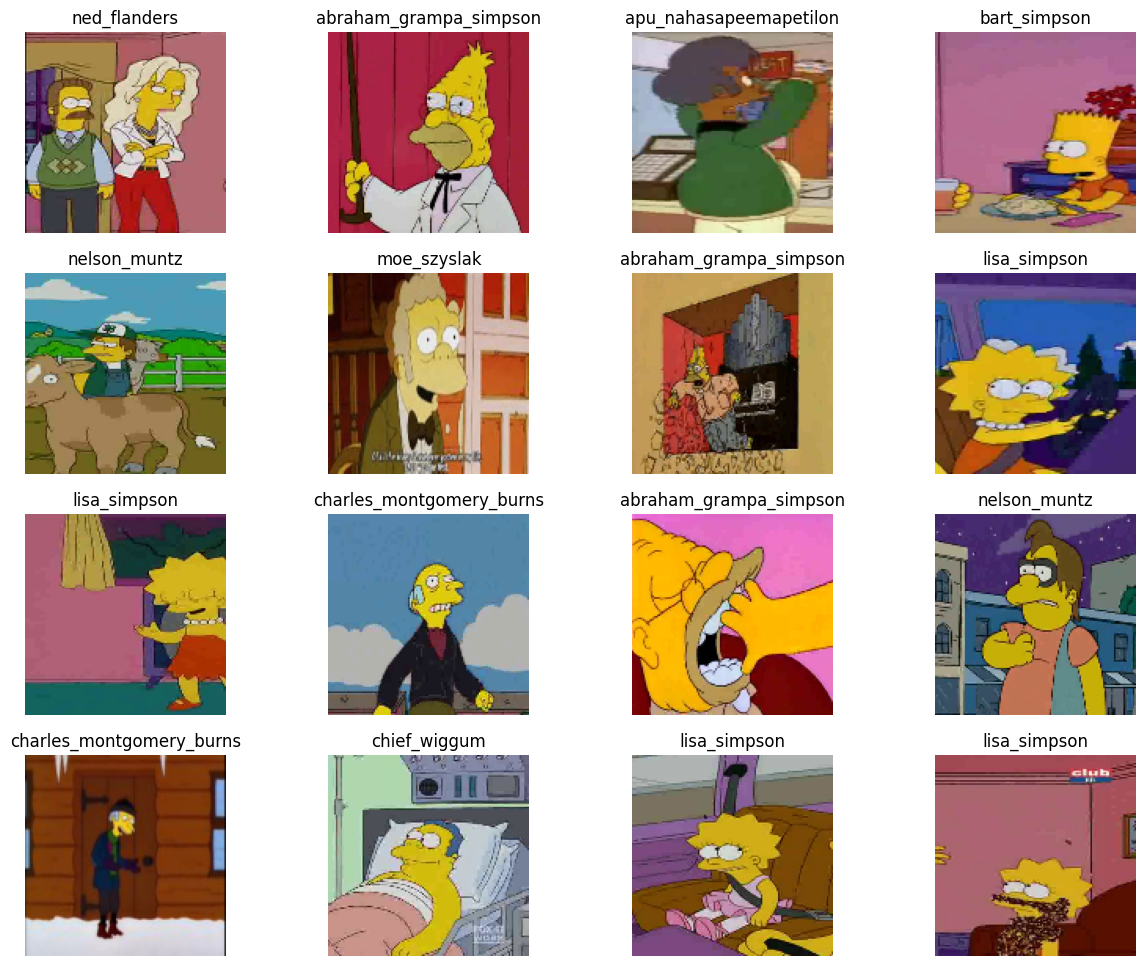

In [100]:
it = iter(val_data)
ims, labels = next(it)
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
for i in range(0, 4):
    for j in range(0, 4):
        axs[i, j].imshow(ims[4*i+j].permute(1, 2, 0).to(dtype=torch.int64))
        axs[i, j].set_title(train_dataset.names[int(labels[4*i+j])])
        axs[i, j].axis("off")


## NN

In [123]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding="same")
        self.conv2 = nn.Conv2d(12, 24, 3, padding="same")
        self.conv3 = nn.Conv2d(24, 24, 3, padding="same")
        self.conv4 = nn.Conv2d(24, 16, 3, padding="same")
        
        self.pool = nn.MaxPool2d(2)
        self.drop_layer = nn.Dropout(0.4)

        self.fc1 = nn.Linear(16 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 42)
            
    def forward(self, x):
        x = self.drop_layer(self.pool(F.relu(self.conv1(x))))
        
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.drop_layer(self.pool(x))

        x = self.drop_layer(self.pool(self.conv4(x)))
        
        x = x.view(-1, 16 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.drop_layer(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



In [124]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [125]:
torch.cuda.empty_cache()

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [127]:
train_loss = []
val_loss = []

In [128]:
epochs = 100

for _e in range(epochs):
    
    net.train()
    net.to(device)

    #acc_mean = 0
    loss_mean = 0
    lm_count = 0
 
    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        output = net(x_train)
        optimizer.zero_grad()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")
    
    train_loss.append(loss_mean)

    net.eval()
    loss_mean = 0
    lm_count = 0
 
    val_tqdm = tqdm(val_data, leave=True)
    
    with torch.no_grad():
        for x_val, y_val in val_tqdm:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
    
            output = net(x_val)
            loss = criterion(output, y_val)
            
            lm_count += 1
            loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
            val_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")
    
    val_loss.append(loss_mean)

Epoch [26/100], loss_mean=0.242:  16%|█▍       | 23/148 [00:04<00:25,  5.00it/s]


KeyboardInterrupt: 

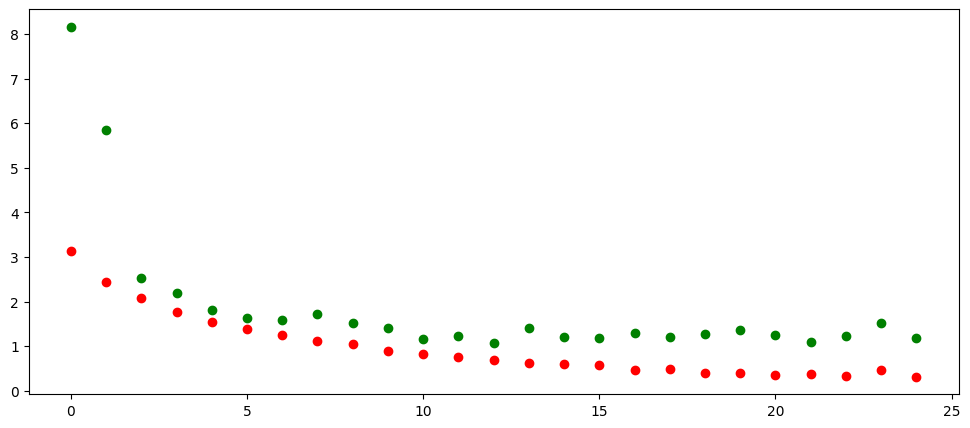

In [131]:
plt.figure(figsize=(12, 5))

plt.scatter(np.arange(0, 25), train_loss, color='red')
plt.scatter(np.arange(0, 25), val_loss, color='green')

In [132]:
torch.save(net.state_dict(), 'cnn_model.pth')

# Validation

In [133]:
model = Net()
model.load_state_dict(torch.load('cnn_model.pth'))

images = []
file = open('testset/images.txt', 'r')
for line in file:
    images.append(line.rstrip())
file.close()

labels = []
t = 0
for i in images:
    path = "".join(['testset/', i])
    im = cv.imread(path)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    im_torch = torch.tensor(cv.resize(im, (128, 128)), dtype=torch.float32).permute(2, 0, 1)
    vec = np.argmax(model(im_torch).detach().numpy())
    labels.append(names[vec])
    t+=1

In [134]:
import pandas as pd

In [135]:
final = pd.DataFrame()
final["Id"] = images
final["Expected"] = labels

In [136]:
final.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img100.jpg,chief_wiggum
2,img101.jpg,apu_nahasapeemapetilon
3,img102.jpg,kent_brockman
4,img103.jpg,edna_krabappel


In [137]:
final.to_csv('output_file.csv', index=False)